In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from models.HybridModel import HybridArchiSimplified
import pyarrow.parquet as pq
from datasets.dataOps import create_datasets, create_dataloaders

# Import IDs

In [2]:
table = pq.read_table("data/info_ts.parquet")
ids = table.to_pandas().index.to_list()

In [3]:
data = {}
for array in ["static_data", "before_ts", "after_ts", "target_ts", "mask_target", "cat_dicos"]:
        with open(f"data/agrial_yield_mlp/{array}.pkl", "rb") as f:
            data[array] = pickle.load(f)

In [4]:
hyperparameters = {
    # Model parameters
    "input_dim": 9, # Number of static numerical and categorical static features
    "input_dim_gru": 7, # Number of dynamic features
    "list_unic_cat": [len(dico.keys()) for dico in data["cat_dicos"].values()],
    "embedding_dims": [254, 254, 254, 254],
    "gru_num_layers": 2,
    "hidden_dim_gru": 256,
    "hidden_dim": 512,
    "output_dim": 1,

    # Training cycle parameters
    "batch_size": 64,
    "max_norm": 1.0,
    "learning_rate": 1e-5,
    "num_epochs": 100,
    }

In [5]:
train_dataset, val_dataset, test_dataset = create_datasets(ids=ids,
                                                           static_data=data["static_data"],
                                                           before_ts=data["before_ts"],
                                                           after_ts=data["after_ts"],
                                                           target_ts=data["target_ts"],
                                                           mask_target=data["mask_target"],
                                                           train_size=0.6,
                                                           val_size=0.2,
                                                           raw_data_folder="data/agrial_yield_mlp/",
                                                           target_mode="yield",
                                                           type_of_dataset="AgrialHybridDataset"
                                                           )
    
train_loader, val_loader, test_loader = create_dataloaders(train_dataset,
                                                               val_dataset,
                                                               test_dataset,
                                                               batch_size=hyperparameters["batch_size"])


          Train_DS = 120051 obs
          Val_DS = 40017 obs
          Test_DS = 40018 obs
          


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)

model = HybridArchiSimplified(
        input_dim=hyperparameters["input_dim"],
        input_dim_gru=hyperparameters["input_dim_gru"],
        list_unic_cat=hyperparameters["list_unic_cat"],
        embedding_dims=hyperparameters["embedding_dims"],
        num_gru_layers=hyperparameters["gru_num_layers"],
        hidden_dim_gru=hyperparameters["hidden_dim_gru"],
        hidden_dim=hyperparameters["hidden_dim"],
        output_dim=hyperparameters["output_dim"]
    ).to(device)


Using device: cuda


In [7]:
checkpoint = torch.load("checkpoints/18_yield_HM_100_eps/best_model.pth")
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [8]:
# Import Means and Standard Deviations
with open("data/agrial_yield_mlp/means_and_stds.pkl", "rb") as f:
    means_and_stds = pickle.load(f)


In [9]:
model.eval()

with torch.no_grad():
    batch_hat_target = []
    batch_target = []
    ids = []
    for batch in test_loader:
        ids.append(batch["id"])
        static_data_cat = batch["static_data_cat"].to(device)
        static_data_num = batch["static_data_num"].to(device)
        meteo_ts = batch["meteo_ts"].to(device)
        target_ts = batch["target_ts"].to(device)
        outputs = model(static_data_num, static_data_cat, meteo_ts)

        batch_hat_target.append(outputs)
        batch_target.append(target_ts)

In [10]:
batch_hat_target[0].shape

torch.Size([128])

In [11]:
concat_batch_hat_target = torch.cat(batch_hat_target, dim=0).to("cpu")
concat_batch_target = torch.cat(batch_target, dim=0).to("cpu")

In [12]:
print(ids[0][:5])

['0000272c-937b-4443-b03a-5ced9097d25f', '00005f52-b45c-4e3f-9c9c-b7c896cb38c1', '00006e3a-e587-4d7f-8884-3ab37cbce21e', '0000af21-ce67-4f73-846c-9b4ba100ff19', '0000ea6a-b8dd-4e3d-9a68-2f03e3e3351a']


In [13]:
# RMSE and MAE
rmse = torch.sqrt(torch.mean((concat_batch_hat_target - concat_batch_target)**2))
mae = torch.mean(torch.abs(concat_batch_hat_target - concat_batch_target))
print(f"RMSE: {rmse.item():.4f}")
print(f"MAE: {mae.item():.4f}")

RMSE: 2919.0732
MAE: 1935.8458


In [14]:
concat_batch_hat_target.max(), concat_batch_hat_target.min()

(tensor(27862.4297), tensor(-2.0786))

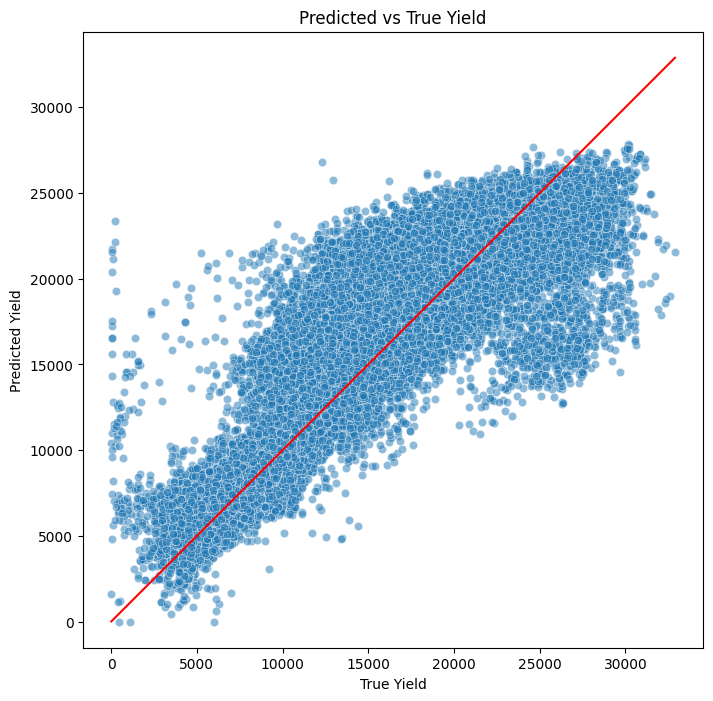

In [15]:
# Scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=concat_batch_target.squeeze().numpy(), y=concat_batch_hat_target.squeeze().numpy(), alpha=0.5)
plt.plot([concat_batch_target.min(), concat_batch_target.max()], [concat_batch_target.min(), concat_batch_target.max()], 'r')
plt.xlabel("True Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs True Yield")
plt.axis('equal')
plt.show()